In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [13]:
cd /content/gdrive/My Drive/TARP/yolov5

/content/gdrive/My Drive/TARP/yolov5


In [14]:
!pip install -qr requirements.txt  
import torch

from IPython.display import Image, clear_output 
from utils.downloads import attempt_download  

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.0.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Xgj9V3xRziKFbRdCAhR9")
project = rf.workspace("idciti").project("droneandbird")
dataset = project.version(2).download("yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to droneandbird-2 in yolov5pytorch:: 100%|██████████| 4728/4728 [00:28<00:00, 163.99it/s]


In [15]:
%cat /content/gdrive/MyDrive/TARP/yolov5/droneandbird-2/data.yaml

names:
- drone
nc: 1
roboflow:
  license: CC BY 4.0
  project: droneandbird
  url: https://universe.roboflow.com/project/droneandbird/dataset/2
  version: 2
  workspace: project
test: ../test/images
train: droneandbird-2/train/images
val: droneandbird-2/valid/images


# Define Model Configuration and Architecture

In [16]:
import yaml
with open('/content/gdrive/MyDrive/TARP/yolov5/droneandbird-2' + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [17]:
#this is the model configuration we will use for our tutorial 
%cat /content/gdrive/MyDrive/TARP/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [18]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [19]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  
depth_multiple: 0.33
width_multiple: 0.50 

# anchors
anchors:
  - [10,13, 16,30, 33,23]  
  - [30,61, 62,45, 59,119]  
  - [116,90, 156,198, 373,326] 

# YOLOv5 backbone
backbone:

  [[-1, 1, Focus, [64, 3]],  
   [-1, 1, Conv, [128, 3, 2]], 
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]], 
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]], 
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]], 
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  
  ]

head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [512, False]],  

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [256, False]],  

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [512, False]],  

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  
   [-1, 3, BottleneckCSP, [1024, False]],  

   [[17, 20, 23], 1, Detect, [nc, anchors]], 
  ]

# Training the Model

In [21]:
%%time
%cd /content/gdrive/MyDrive/TARP/yolov5/
!python train.py --img 416 --batch 16 --epochs 70 --data /content/gdrive/MyDrive/TARP/yolov5/droneandbird-2/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/gdrive/My Drive/TARP/yolov5
2023-04-18 15:43:23.349536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 15:43:24.446983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/gdrive/MyDrive/TARP/yolov5/droneandbird-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=70, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing

# Performance Evaluation

In [22]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


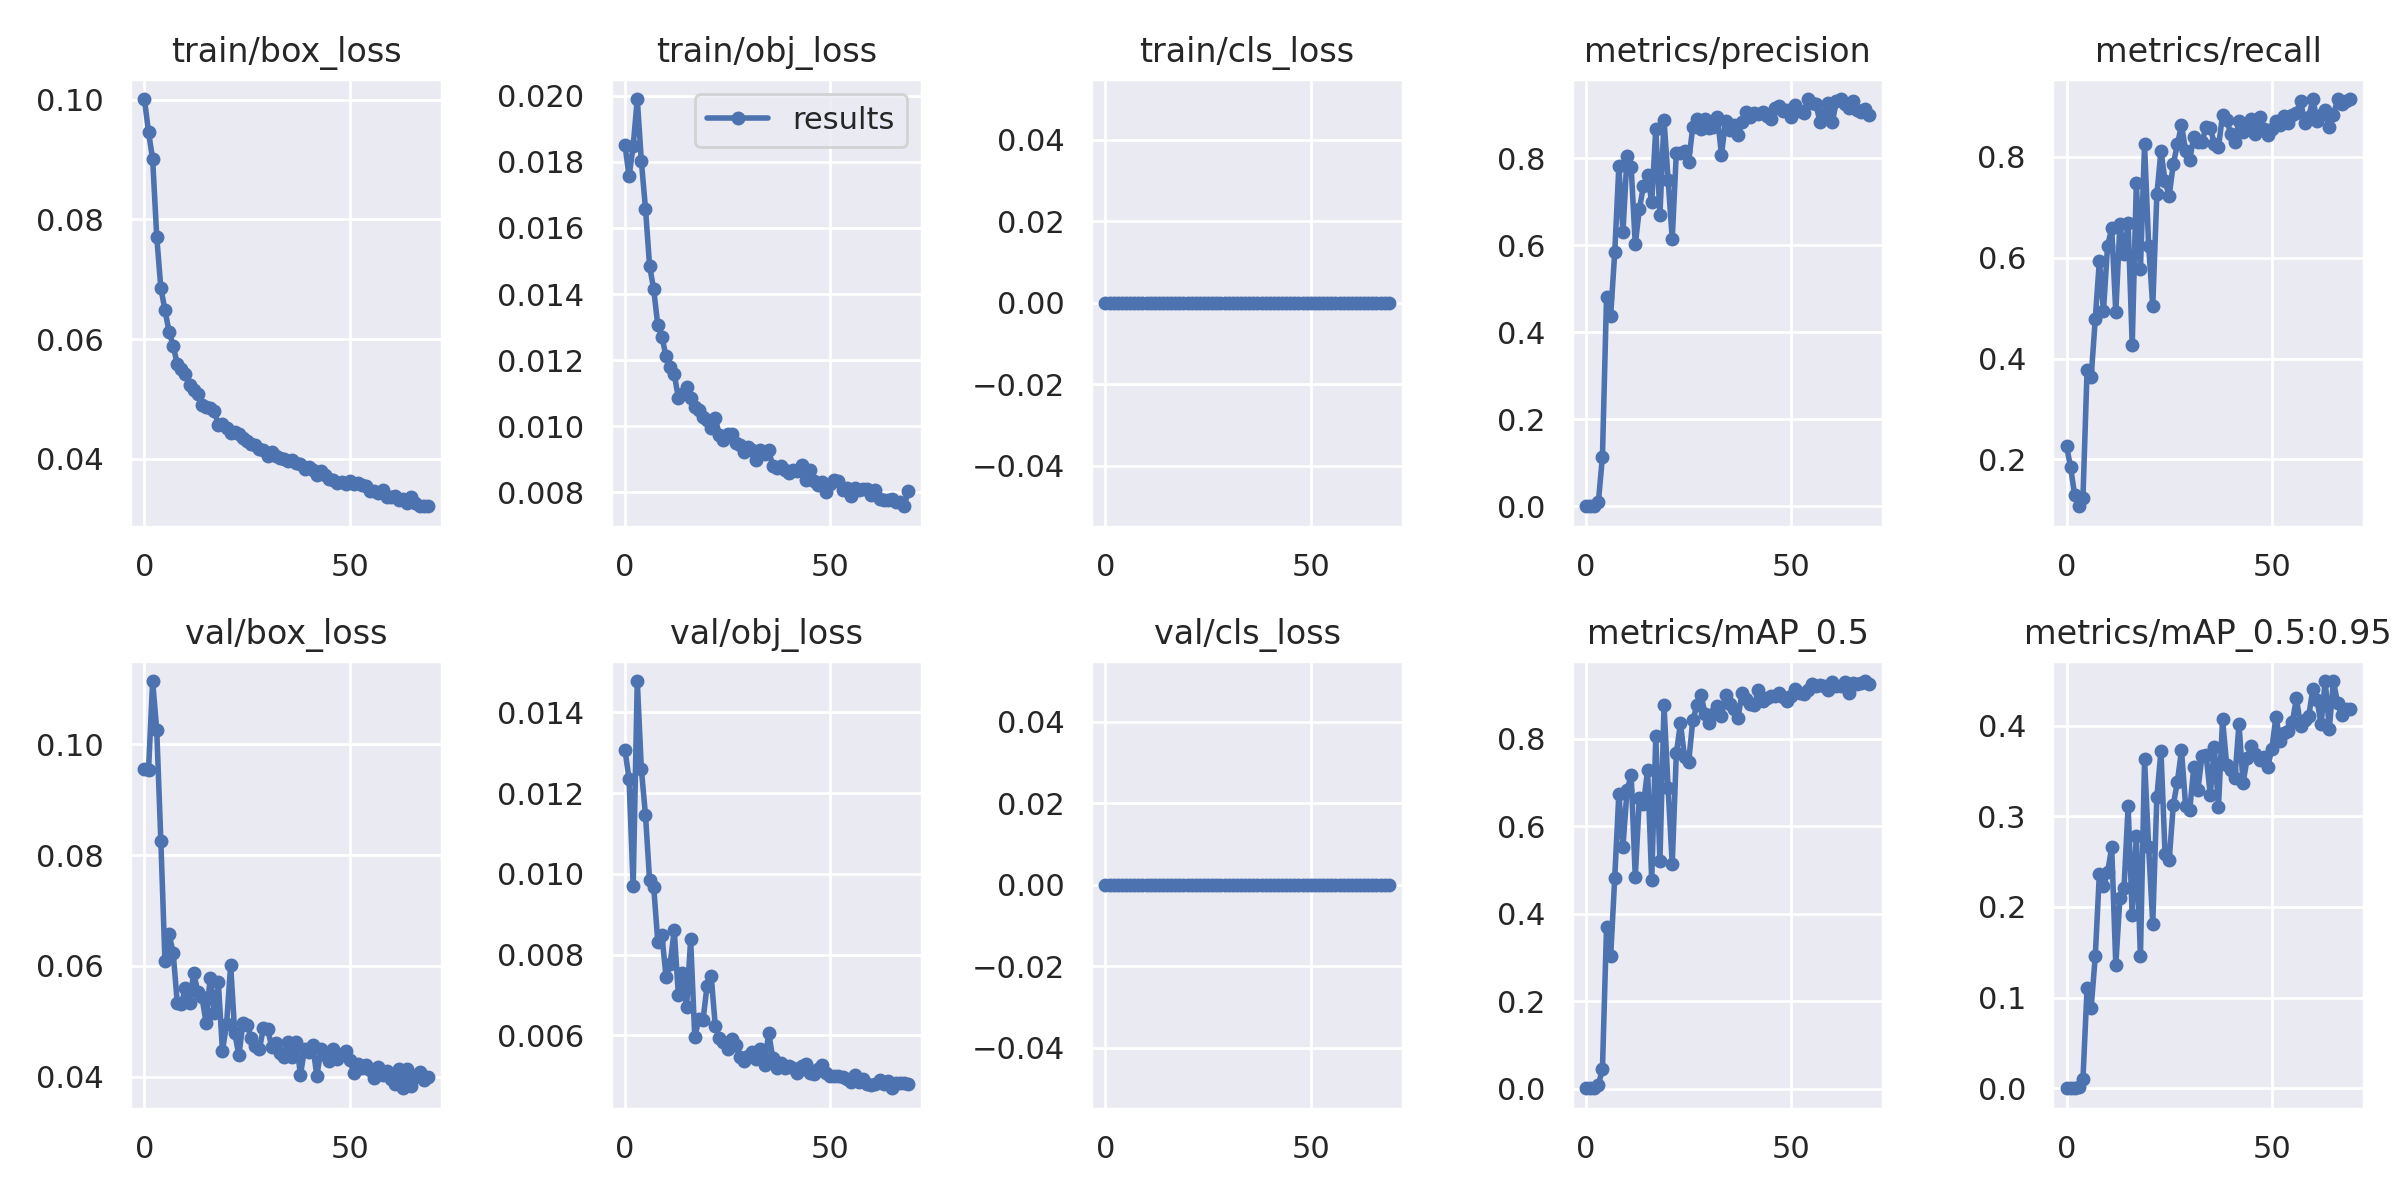

In [25]:
from utils.plots import plot_results  
Image(filename='/content/gdrive/MyDrive/TARP/yolov5/runs/train/yolov5s_results4/results.png', width=1000)  

GROUND TRUTH TRAINING DATA:


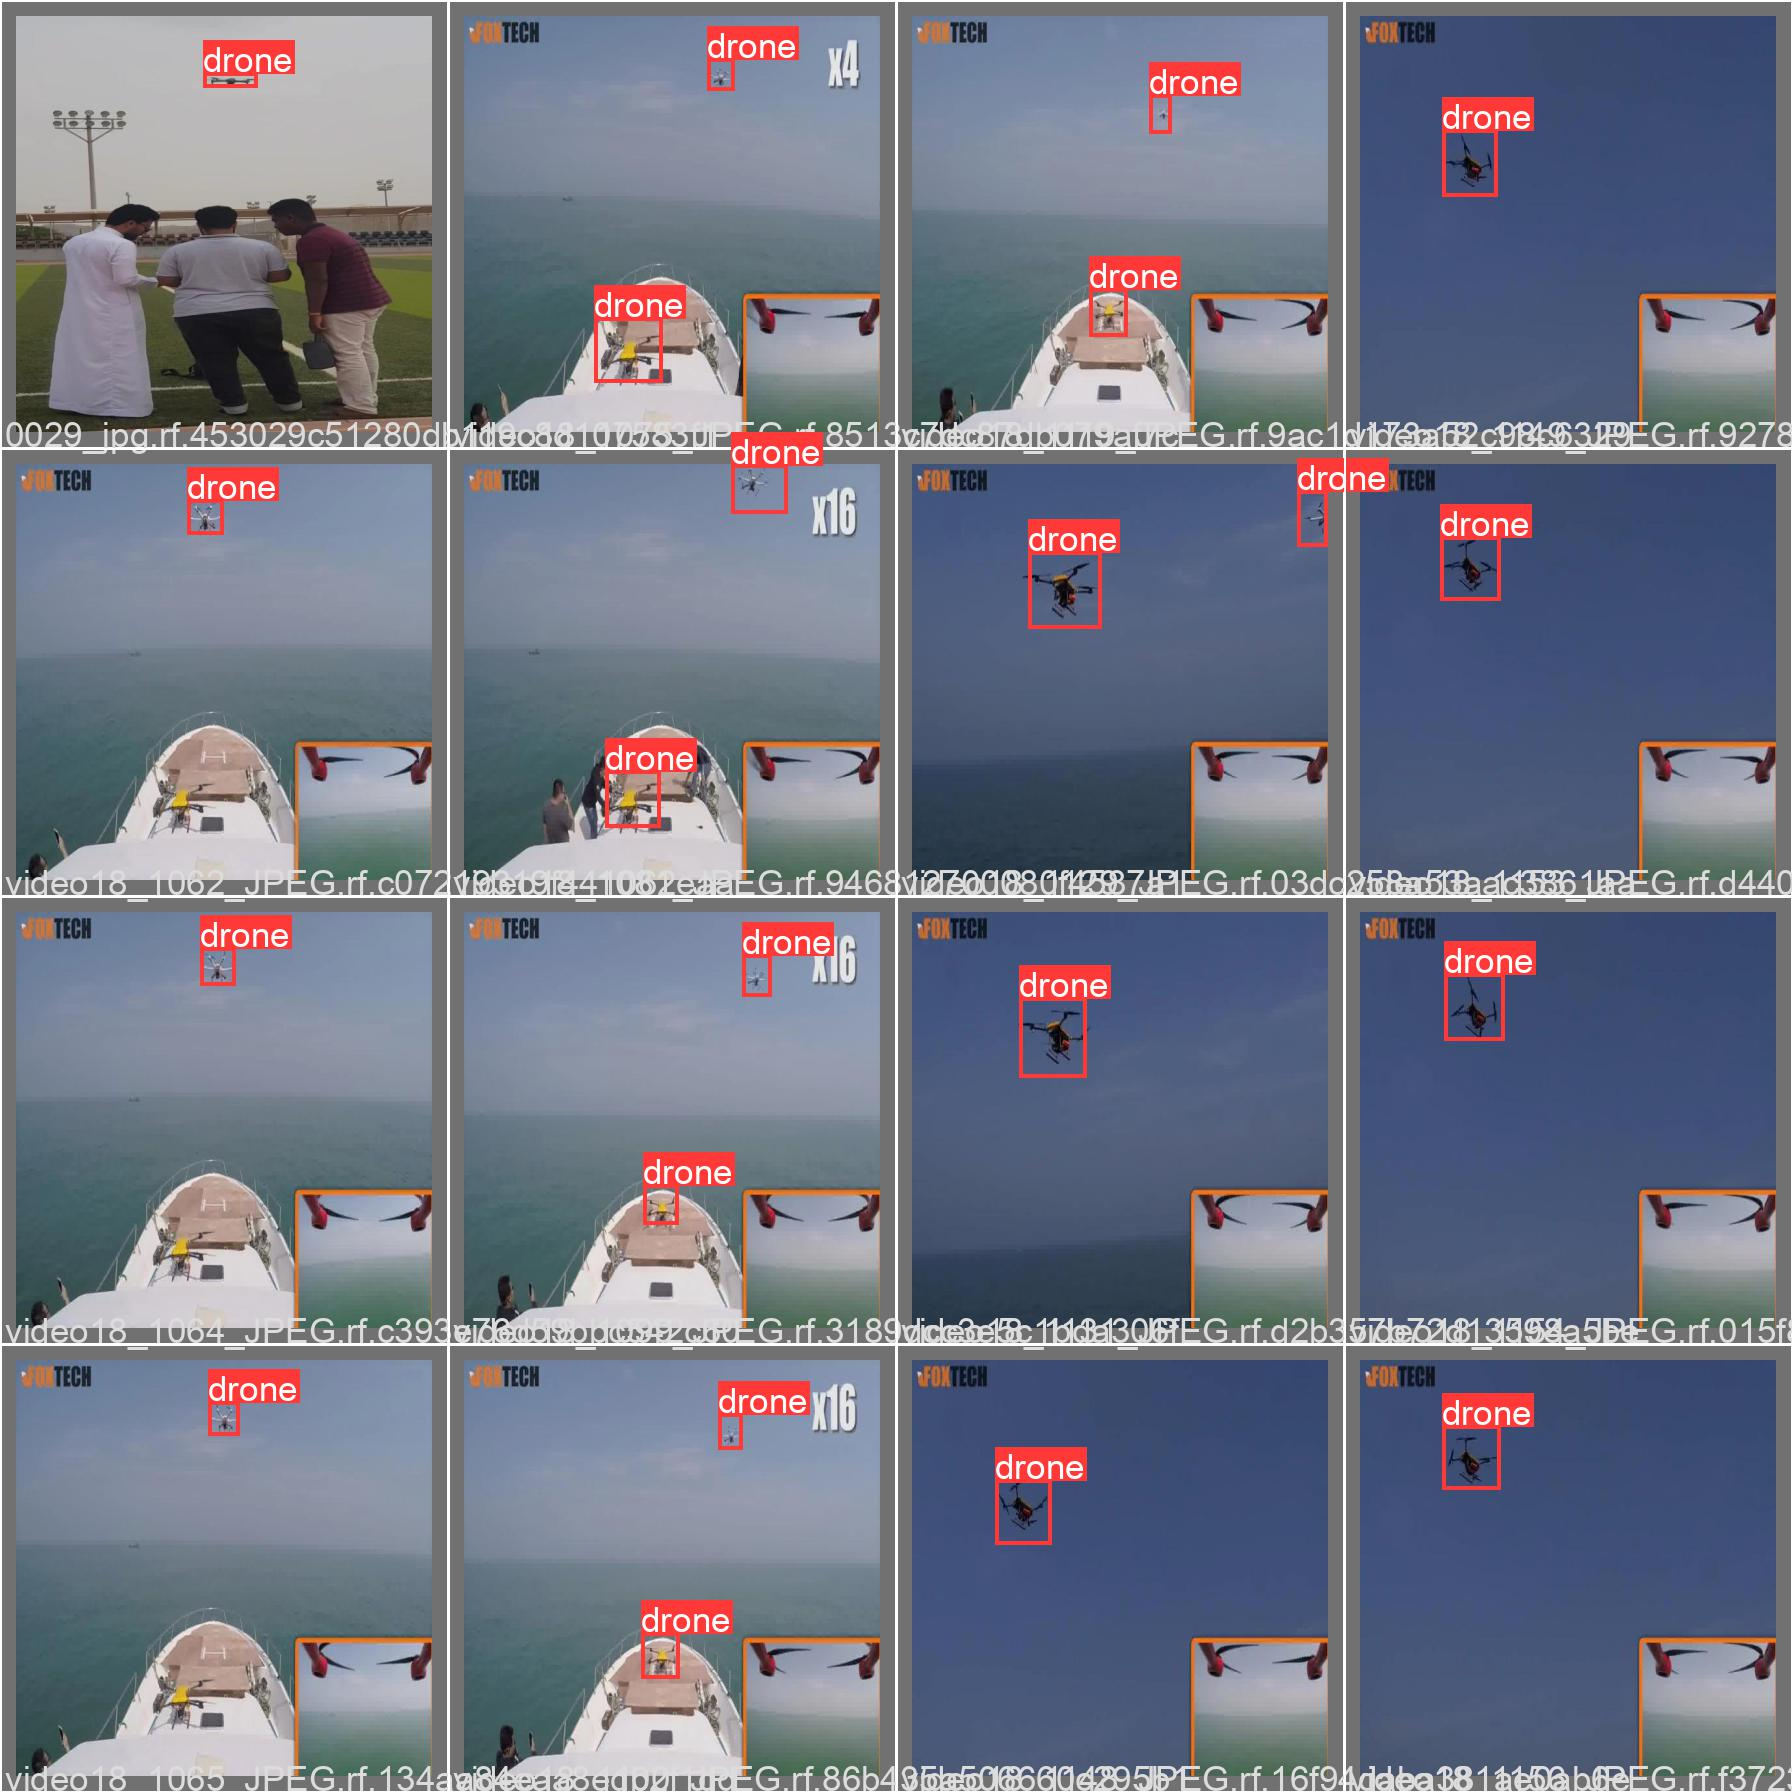

In [26]:
Image(filename='/content/gdrive/MyDrive/TARP/yolov5/runs/train/yolov5s_results4/val_batch0_labels.jpg', width=900)

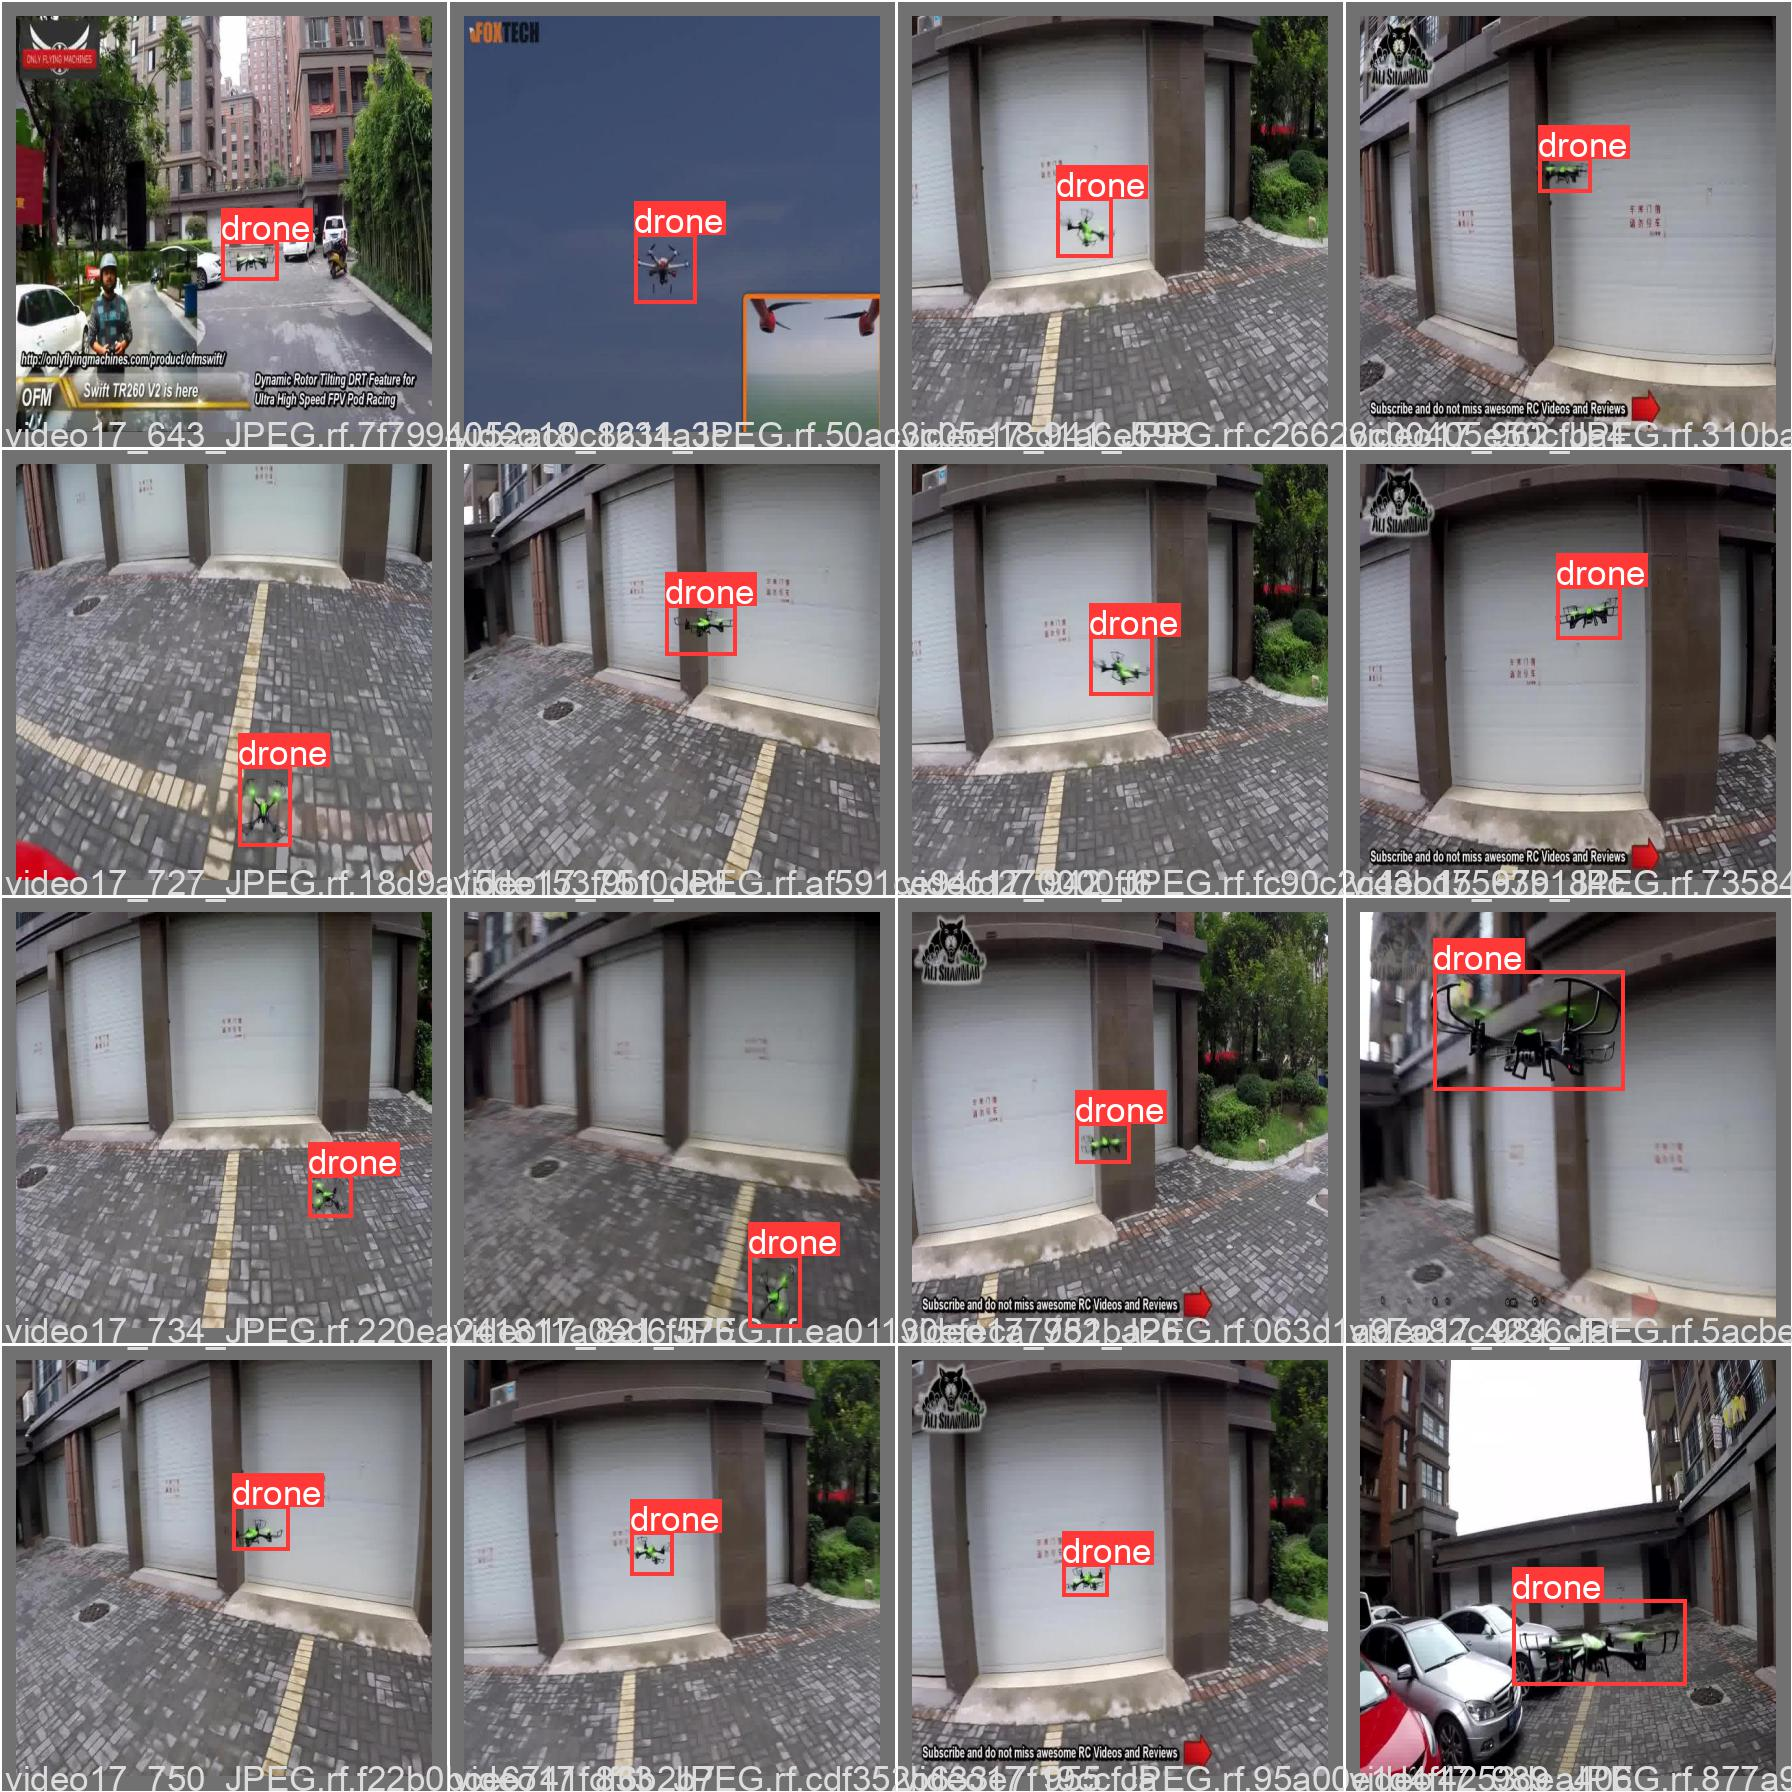

In [27]:
Image(filename='/content/gdrive/MyDrive/TARP/yolov5/runs/train/yolov5s_results4/val_batch1_labels.jpg', width=900)

#Run Inference  With Trained Weights

In [28]:
%ls runs/

detect/  train/


In [29]:
%ls runs/train/yolov5s_results4/weights

best.pt  last.pt


In [30]:
%cd /content/gdrive/MyDrive/TARP/yolov5/
!python detect.py --weights runs/train/yolov5s_results4/weights/best.pt --img 416 --conf 0.4 --source ./droneandbird-2/test/images

/content/gdrive/My Drive/TARP/yolov5
detect: weights=['runs/train/yolov5s_results4/weights/best.pt'], source=./droneandbird-2/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
image 1/89 /content/gdrive/MyDrive/TARP/yolov5/droneandbird-2/test/images/0014_jpg.rf.27ae2969785e55ce4d299fa5f3ca7692.jpg: 416x416 1 drone, Done. (0.008s)
image 2/89 /content/gdrive/MyDrive/TARP/yolov5/droneandbird-2/test/images/0266_jpg.rf.6a7df4f26675092badb8543e00071b89.jpg: 416x416 1 dron

/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/0014_jpg.rf.27ae2969785e55ce4d299fa5f3ca7692.jpg


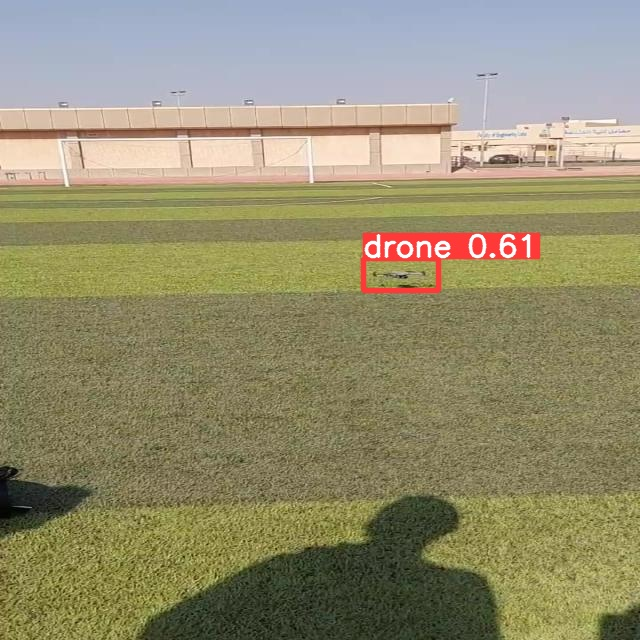



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/0266_jpg.rf.6a7df4f26675092badb8543e00071b89.jpg


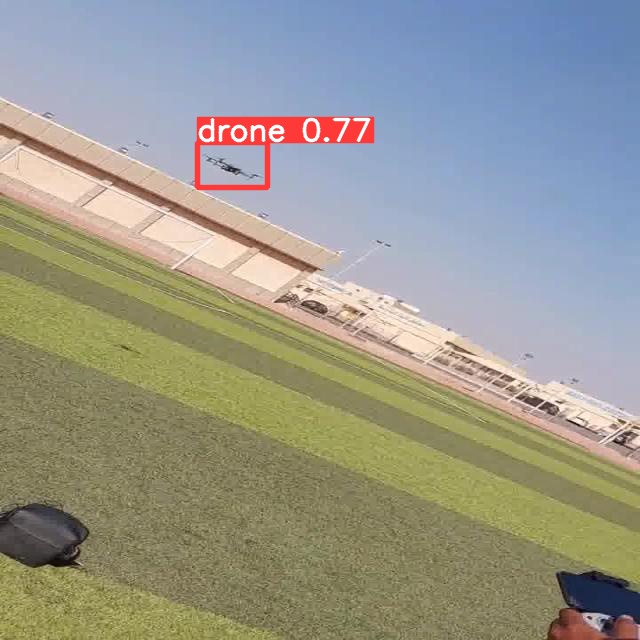



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/0269_jpg.rf.9f38826d07ff905bd916c4d5ab0abfcd.jpg


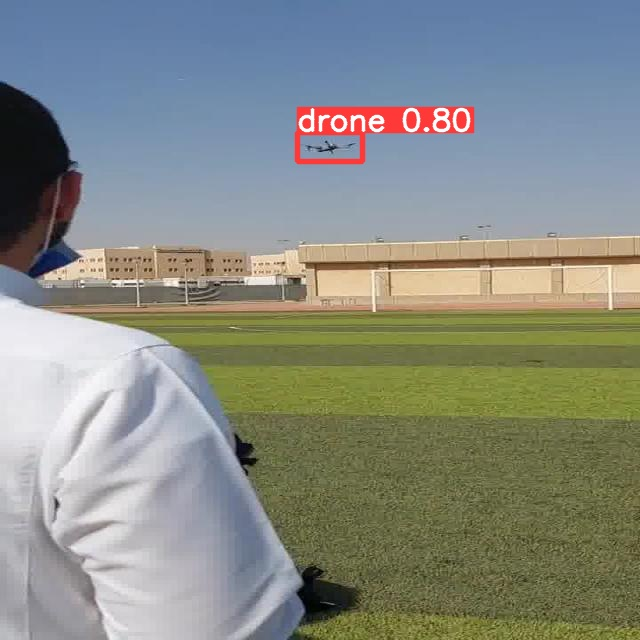



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/0388_jpg.rf.cf424f995e088bdc61ce1d03f0a7c3d4.jpg


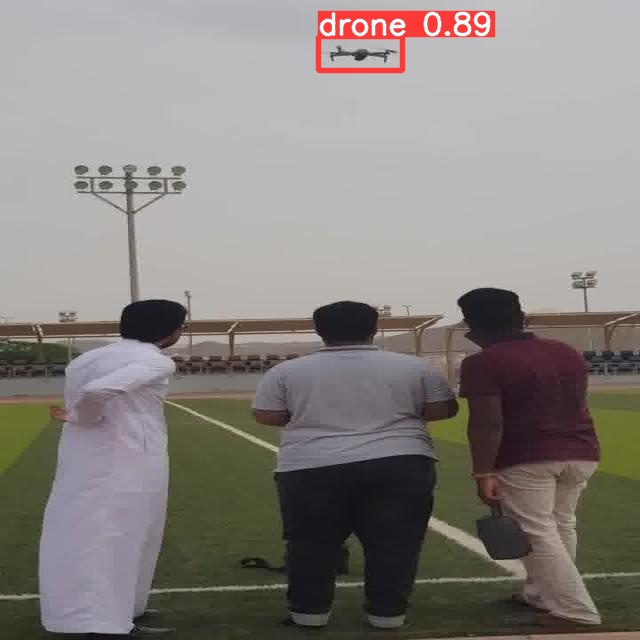



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/0452_jpg.rf.bfa1f64865c7f0a735e01193009ce08e.jpg


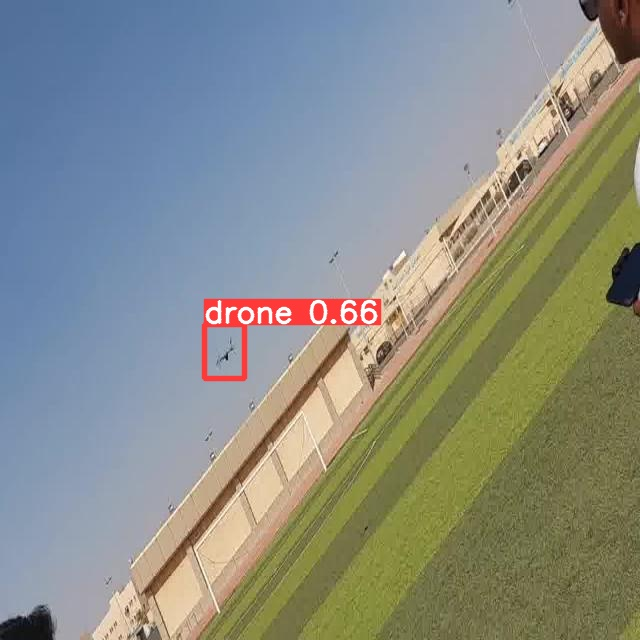



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/0482_jpg.rf.d2d207d9c80c719b918646235ba040ec.jpg


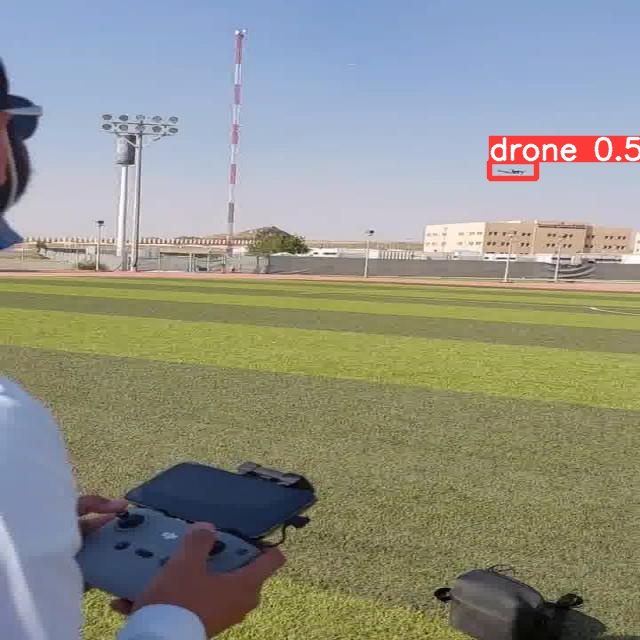



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/107_JPEG.rf.21badbafe8b5418692257c2f2cfea947.jpg


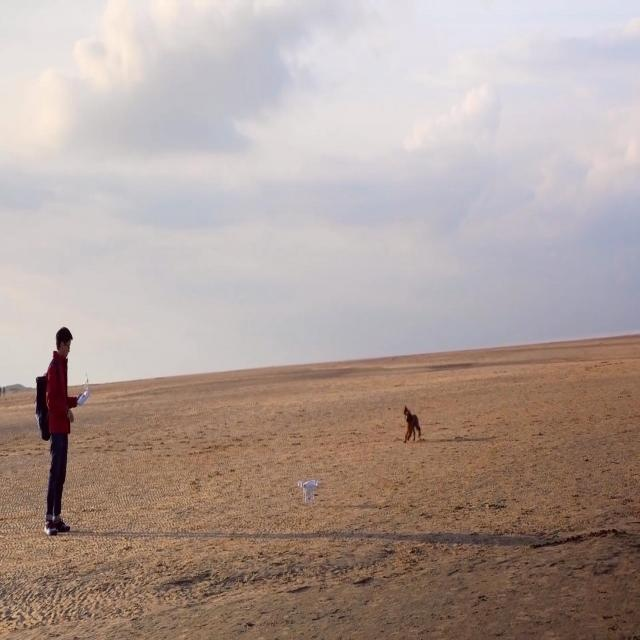



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/124_JPEG.rf.6d66680262c5bc1d22deb0395b3232c6.jpg


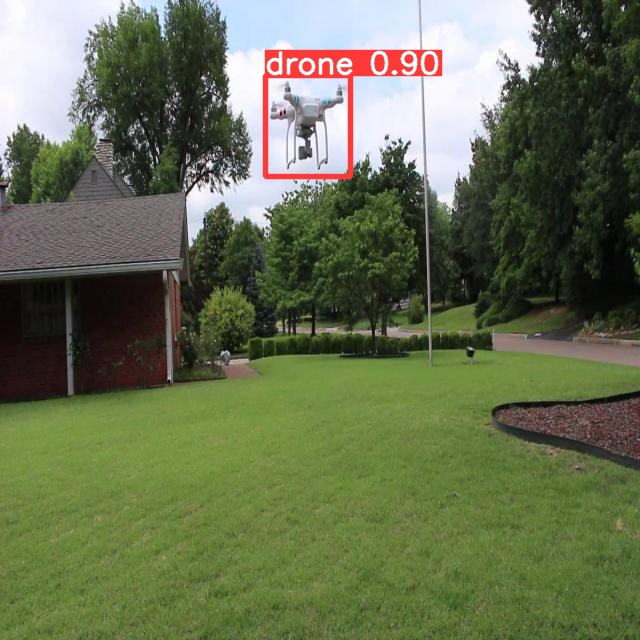



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/156_JPEG.rf.1e8ef2c875fe8fb0d69dc4cbff43f21e.jpg


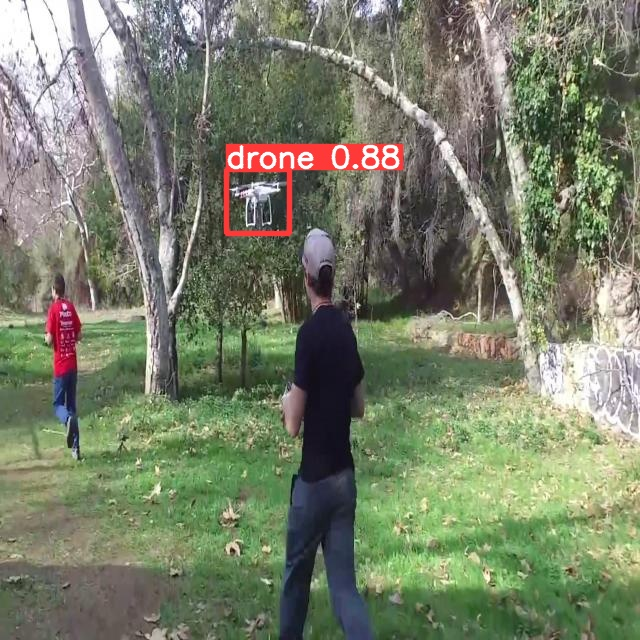



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/173_JPEG_jpg.rf.abe24179ad775cc9ed8685a1a3c28400.jpg


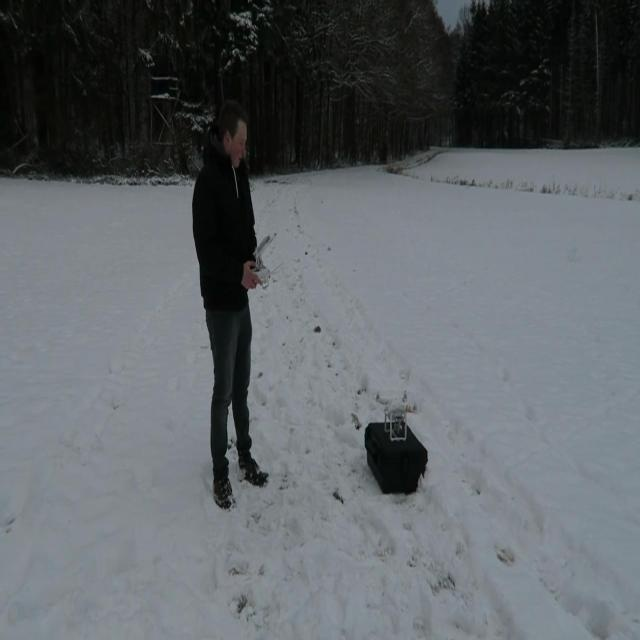



/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/194_JPEG.rf.b6dc2cdbd5b72081026d04e42fb4f15c.jpg


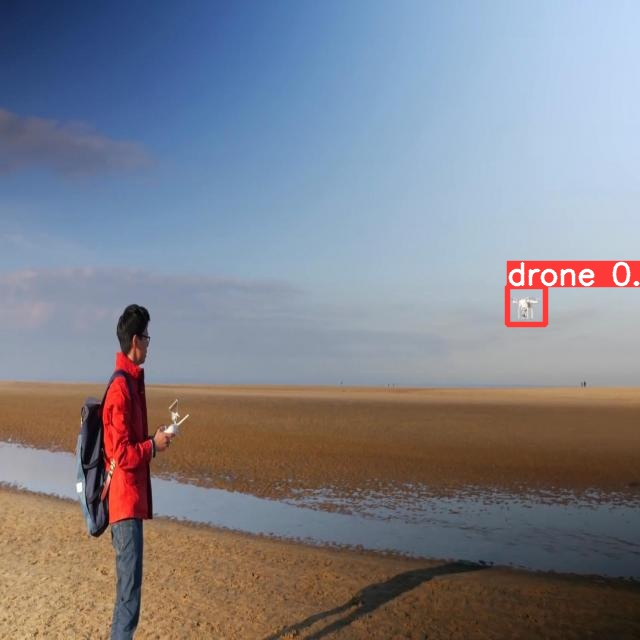

In [31]:
import glob
from IPython.display import Image, display

i=0

for imageName in glob.glob('/content/gdrive/MyDrive/TARP/yolov5/runs/detect/exp6/*.jpg'): 
    print(imageName)
    display(Image(filename=imageName))
    print("\n")

    i+=1

    if i>10:
      break

In [32]:
%cd /content/gdrive/MyDrive/TARP/yolov5/
!python detect.py --weights runs/train/yolov5s_results4/weights/best.pt --img 416 --conf 0.4 --source https://www.youtube.com/watch?v=PmvFC07pCbc

Streaming output truncated to the last 5000 lines.
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.012s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.010s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.008s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.008s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Do

In [33]:
%cd /content/gdrive/MyDrive/TARP/yolov5/
!python detect.py --weights runs/train/yolov5s_results4/weights/best.pt --img 416 --conf 0.4 --source https://www.youtube.com/watch?v=ROQcLXrUxYE

Streaming output truncated to the last 5000 lines.
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.010s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.012s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.009s)
0: 256x416 Done. (0.010s)
0: 256x416 Done. (0.014s)
0: 256x416 Done. (0.008s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.009s)
0: 256x416 Done. (0.011s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.008s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.006s)
0: 256x416 Done. (0.007s)
0: 256x416 Done. (0.006s)
0: 256x416 Do